# Projet MonGueuleTon

Nous allons dans ce notebook entrainer un classifieur d'image de nourriture, avec la base de donnée *Food-101*.   

Cette base de donnée est composée de 101 catégories d'images, chacune composés de 1000 exemple d'images.

## Imports

In [4]:
import pandas as pd
import requests
import glob
from io import BytesIO
import numpy as np
import os
import shutil
import pprint
import json


In [5]:
from fastai import *
from fastai.vision import *
from fastai.imports import *
from fastai.vision import *

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Extraction des données


In [15]:
#!mkdir -p ../data
#!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz -P ../data
#!tar xzf ../data/food-101.tar.gz -C ../data

--2020-10-31 15:29:22--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Résolution de data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)… 129.132.52.162
Connexion à data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80… connecté.
requête HTTP transmise, en attente de la réponse… 302 Found
Emplacement : https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [suivant]
--2020-10-31 15:29:22--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connexion à data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 4996278331 (4,7G) [application/x-gzip]
Enregistre : «../data/food-101.tar.gz»

food-101.tar.gz     100%[===================>]   4,65G  48,9MB/s    ds 94s     

2020-10-31 15:30:56 (50,7 MB/s) - «../data/food-101.tar.gz» enregistré [4996278331/4996278331]



## Chargement des données

Chacune des 101 catégories ou classes sont stockés dans un dossier

In [4]:
!ls data

food-101  food-101.tar.gz


In [5]:
!ls data/food-101/

classes.txt  images  license_agreement.txt  meta  README.txt


- Les 5 premières catégories

In [6]:
!ls data/food-101/images | head -n 5

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare


Chemin vers les images 

In [7]:
path = Path('data/food-101/images')

In [8]:
from fastai.vision.all import *

In [9]:
#data = ImageDataBunch.from_folder(path, valid_pct=0.2,
#        ds_tfms=get_transforms(), size=224, num_workers=8, bs=64).normalize(imagenet_stats)

data = ImageDataLoaders.from_folder(path, valid_pct=0.2, 
    item_tfms=RandomResizedCrop(224),num_workers=8, bs=64, batch_tfms=Normalize.from_stats(*imagenet_stats))

In [10]:
#data.classes, data.c, len(data.train_ds), len(data.valid_ds)

# Entrainement du modèle

## Initialisation

In [10]:
import torchvision.models as models

In [11]:
#learn = create_cnn(data, models.resnet34, metrics=error_rate,pretrained=True)
learn = cnn_learner(data, models.resnet34, metrics=error_rate, pretrained=True)

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=7.585775847473997e-07)

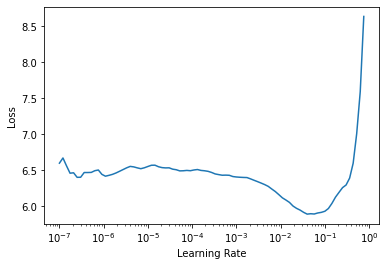

In [20]:
learn.lr_find()
#learn.recorder.plot(suggestion=True)

In [11]:
#learn = create_cnn(data, models.resnet34, metrics=error_rate, model_dir="../../prod")
#learn.model = torch.nn.DataParallel(learn.model)


In [21]:
lr = 1e-2

In [22]:
learn.fit_one_cycle(8 , lr)

epoch,train_loss,valid_loss,error_rate,time
0,2.536750,2.084654,0.528168,03:39
1,2.359736,2.141263,0.540198,03:40
2,2.205033,1.636847,0.424802,03:41
3,2.034728,1.570774,0.411040,03:41
4,1.836524,1.355411,0.354059,03:41
5,1.714223,1.247236,0.325396,03:41
6,1.674618,1.187831,0.309703,03:41
7,1.610528,1.176331,0.307129,03:41


In [12]:
model_name="resnet34"

In [24]:
learn.save(f'{model_name}-stage-1')

Path('data/food-101/images/models/resnet34-stage-1.pth')

In [13]:
learn.load(f'{model_name}-stage-1')

In [14]:
learn.unfreeze()


SuggestedLRs(lr_min=5.248074419483828e-10, lr_steep=4.570881895205048e-09)

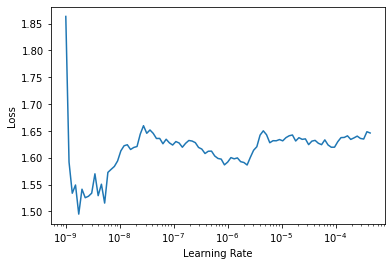

In [15]:
learn.lr_find(start_lr=1e-09, end_lr=1e-3)

In [28]:
#learn.recorder.plot(skip_end=10)


AttributeError: 'Learner' object has no attribute 'plot'

In [16]:
learn.fit_one_cycle(8, max_lr=slice(1e-8,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,2.253990,1.910359,0.490941,04:57
1,2.254642,1.862724,0.475099,04:57
2,1.999908,1.655207,0.428614,04:58
3,1.684700,1.292001,0.339901,04:58
4,1.495644,1.130489,0.300050,04:58
5,1.327868,0.992470,0.264109,04:58
6,1.142251,0.912321,0.243861,04:58
7,1.174223,0.895545,0.237624,04:58


In [17]:
learn.save(f'{model_name}-stage-2')

Path('data/food-101/images/models/resnet34-stage-2.pth')

In [18]:
learn.load(f'{model_name}-stage-2');

## Interpretation

In [19]:
learn.load(f'{model_name}-stage-2');


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [1]:
interp.plot_top_losses(9, figsize=(15,11))


NameError: name 'interp' is not defined

In [2]:
interp.plot_confusion_matrix(figsize=(50,50), dpi=30)


NameError: name 'interp' is not defined

In [27]:
interp.most_confused(min_val=2)


[('filet_mignon', 'steak', 26),
 ('steak', 'filet_mignon', 26),
 ('tuna_tartare', 'beef_tartare', 23),
 ('chocolate_cake', 'chocolate_mousse', 21),
 ('pork_chop', 'filet_mignon', 20),
 ('pork_chop', 'grilled_salmon', 20),
 ('chocolate_mousse', 'chocolate_cake', 19),
 ('prime_rib', 'steak', 18),
 ('ravioli', 'lasagna', 18),
 ('breakfast_burrito', 'huevos_rancheros', 17),
 ('beef_tartare', 'tuna_tartare', 16),
 ('lobster_bisque', 'clam_chowder', 16),
 ('steak', 'pork_chop', 16),
 ('tiramisu', 'chocolate_mousse', 16),
 ('chicken_quesadilla', 'breakfast_burrito', 15),
 ('panna_cotta', 'chocolate_mousse', 15),
 ('ramen', 'pho', 15),
 ('ice_cream', 'frozen_yogurt', 14),
 ('pulled_pork_sandwich', 'hamburger', 14),
 ('sashimi', 'sushi', 14),
 ('tacos', 'nachos', 14),
 ('apple_pie', 'bread_pudding', 13),
 ('crab_cakes', 'falafel', 13),
 ('pork_chop', 'steak', 13),
 ('breakfast_burrito', 'omelette', 12),
 ('cheesecake', 'strawberry_shortcake', 12),
 ('greek_salad', 'beet_salad', 12),
 ('huevos_r

In [28]:
final_model_name = f'{model_name}-final'

In [29]:
learn.save(final_model_name)

# Teste du modèle

### Chargement du modèle entrainé

In [71]:
guacamole_url = "https://upload.wikimedia.org/wikipedia/commons/1/18/Guacamole-lime.jpg"

In [105]:
classif = load_learner('', '../models/model.pkl')


/Users/sylla/Work/Formation/projet_final/mongueuleton/env_mgt/lib/python3.8/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/sylla/Work/Formation/projet_final/mongueuleton/env_mgt/lib/python3.8/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/sylla/Work/Formation/projet_final/mongueuleton/env_mgt/lib/python3.8/site-packages/torch/serialization.py:658: SourceChangeWarning

In [106]:
def charge_img(url):
    response = requests.get(url)
    img = open_image(BytesIO(response.content))
    return img

In [107]:
def predict_two(url):
    img = charge_img(url)
    pred_class,pred_idx,outputs = classif.predict(img)
    res =  zip (classif.data.classes, outputs.tolist())
    predictions = sorted(res, key=lambda x:x[1], reverse=True)
    top_predictions = predictions[0:5]
    pprint.pprint( top_predictions)
    return img.resize(400)

In [108]:
w = "https://upload.wikimedia.org/wikipedia/commons/e/e8/Waffles.png"

/Users/sylla/Work/Formation/projet_final/mongueuleton/env_mgt/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/Users/sylla/Work/Formation/projet_final/mongueuleton/env_mgt/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


[('pulled_pork_sandwich', 0.7674420475959778),
 ('poutine', 0.028409456834197044),
 ('shrimp_and_grits', 0.017370153218507767),
 ('pork_chop', 0.015928875654935837),
 ('hamburger', 0.013365548104047775)]


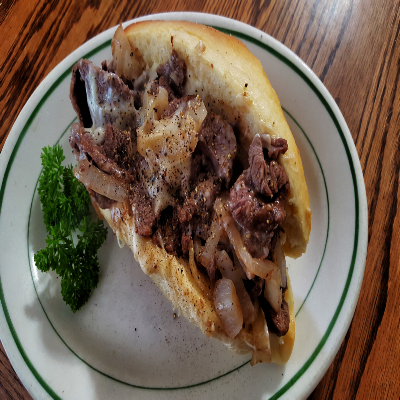

In [109]:
predict_two("https://upload.wikimedia.org/wikipedia/commons/3/34/Cheesesteak_%2819386149993%29.jpg")

In [112]:
learn.load("models/model.pkl");

NameError: name 'learn' is not defined

In [113]:
learn.data.classes

NameError: name 'learn' is not defined

In [115]:
data2 = ImageDataBunch.single_from_classes(path, data.classes
                                           , tfms=get_transforms()
                                           , size=224).normalize(imagenet_stats)
learn = create_cnn(data2, models.resnet34)
learn.load(final_model_name)

NameError: name 'data' is not defined

In [114]:
data2.classes, data2.c

NameError: name 'data2' is not defined

# Vers la Production

To make our model available as a web app, we will need to save:
- final model
- list of class names

Remove existing model artifacts

In [51]:
shutil.rmtree("../models",ignore_errors=True)

Copy the models stored locally to folder above

'/home/ubuntu/projects/food-classifier/notebooks/../models'

In [94]:
final_model_directory = os.getcwd()+ "/../models"
final_model_name='model.pkl'

In [95]:
learn.export(final_model_directory+f"/{final_model_name}")

In [87]:
!pwd

/home/ubuntu/projects/food-classifier/notebooks


Save the list of classes

In [104]:
with open('../models/classes.txt', 'w') as f:
    json.dump(learn.data.classes,f)

NameError: name 'learn' is not defined

## Load 

In [110]:
learn3= load_learner(final_model_directory,final_model_name)

NameError: name 'final_model_directory' is not defined

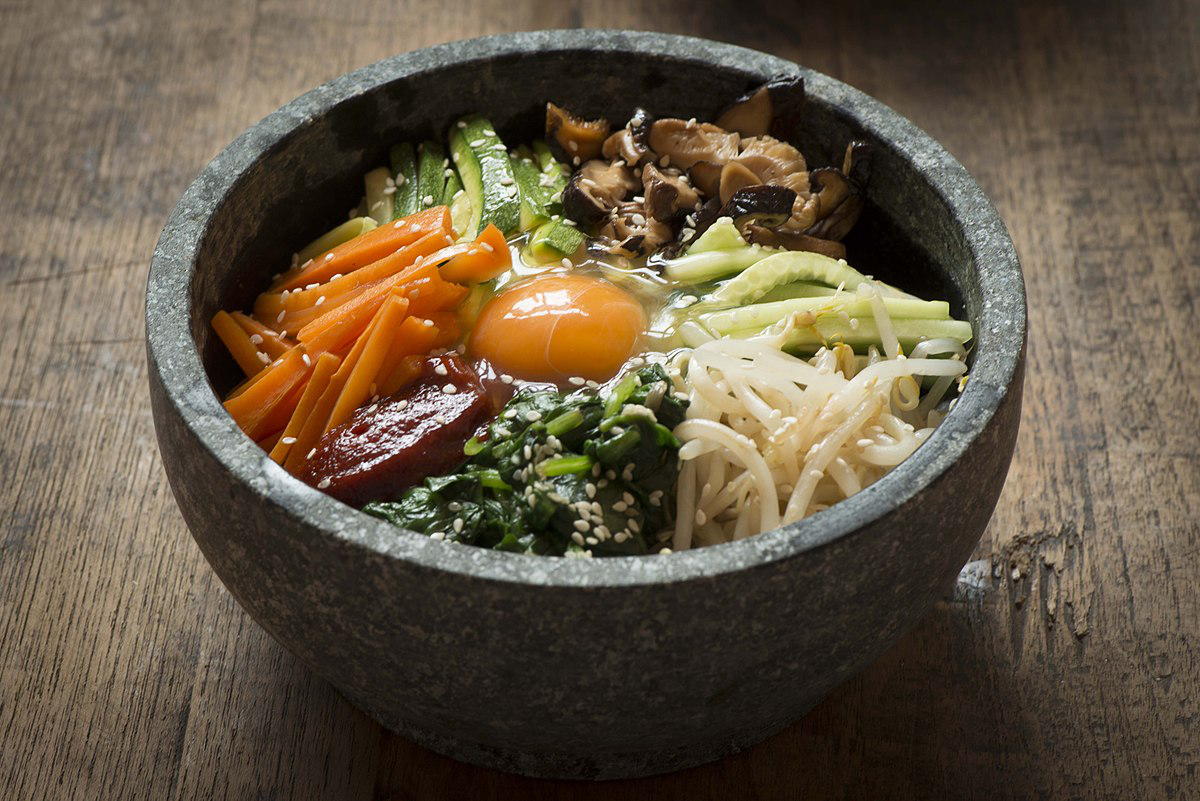

In [100]:
img

In [99]:
learn3.predict(img)

(Category bibimbap,
 tensor(7),
 tensor([7.9646e-07, 4.5580e-06, 1.5296e-06, 1.2509e-06, 8.7913e-06, 2.4522e-04,
         4.5393e-07, 9.5558e-01, 1.7174e-06, 3.3974e-06, 7.6976e-07, 6.4425e-04,
         3.2325e-07, 1.1164e-06, 7.3624e-06, 8.5419e-05, 7.8974e-07, 3.9314e-07,
         7.9545e-04, 4.2051e-06, 1.4746e-06, 1.8886e-05, 3.5605e-04, 1.1198e-06,
         1.6324e-05, 2.4728e-06, 1.6591e-05, 7.6081e-06, 1.4518e-06, 1.5057e-05,
         2.5960e-06, 5.3018e-07, 5.1174e-04, 1.7958e-05, 1.9048e-07, 1.6904e-04,
         2.7631e-04, 5.3418e-05, 2.0619e-06, 3.5094e-06, 1.8902e-06, 6.2659e-05,
         2.5408e-07, 1.4159e-06, 6.8474e-04, 2.4911e-04, 2.1151e-07, 3.5693e-05,
         3.0563e-04, 2.1286e-06, 2.2200e-05, 1.9116e-02, 1.7199e-06, 4.7683e-06,
         2.4722e-05, 1.1216e-06, 2.2922e-04, 1.0237e-03, 1.2317e-05, 1.7914e-06,
         9.4212e-06, 5.8267e-07, 1.8509e-04, 4.4426e-07, 1.4893e-04, 1.1100e-04,
         2.5303e-05, 1.7505e-05, 1.8094e-07, 9.3376e-07, 9.4870e-05, 3.3305e-